In [96]:
!pip install matplotlib

Firstly, we load the data

In [97]:
import pandas as pd

# Load the dataset from the tweet.csv file
file_path = 'tweets.csv'  
tweets_df = pd.read_csv(file_path)
print(tweets_df.head())


  TweetID User   Latitude  Longitude            Timestamp  \
0      t0   u0  25.369607 -91.221811  2024-12-30 22:04:15   
1      t1   u0  25.369858 -91.221340  2024-12-30 20:47:53   
2      t2   u0  25.370009 -91.221451  2024-12-31 06:10:53   
3      t3   u0  25.369709 -91.221401  2024-12-30 20:34:41   
4      t4   u0  25.369543 -91.221533  2024-12-31 04:29:51   

                                  User_home  \
0  [25.369751567063844, -91.22138951933916]   
1  [25.369751567063844, -91.22138951933916]   
2  [25.369751567063844, -91.22138951933916]   
3  [25.369751567063844, -91.22138951933916]   
4  [25.369751567063844, -91.22138951933916]   

                                  User_work  
0  [25.248032402070777, -91.27715508298908]  
1  [25.248032402070777, -91.27715508298908]  
2  [25.248032402070777, -91.27715508298908]  
3  [25.248032402070777, -91.27715508298908]  
4  [25.248032402070777, -91.27715508298908]  


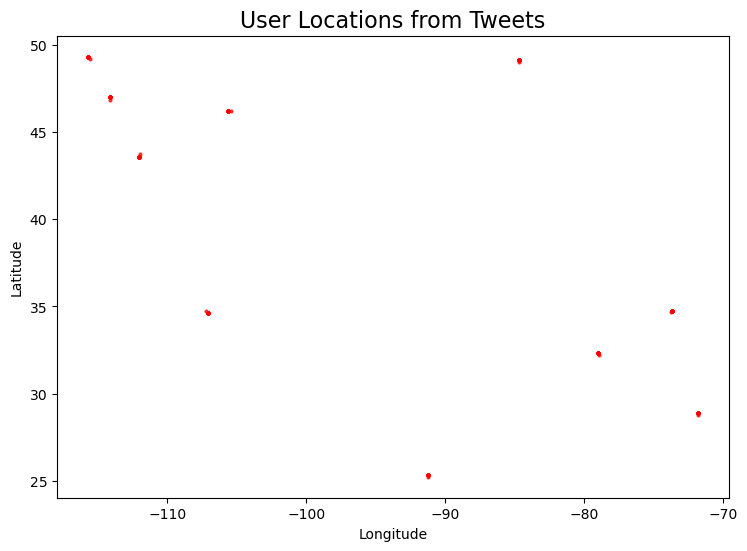

In [98]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point


# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(tweets_df['Longitude'], tweets_df['Latitude'])]
gdf = gpd.GeoDataFrame(tweets_df, geometry=geometry, crs="EPSG:4326")

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, color='red', alpha=0.7, markersize=4)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('User Locations from Tweets', fontsize=16)

plt.show()


Implementation of the techniques used in the paper
1)Random Perturbation
2)Gaussian Perturbation

In [99]:
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle

# Default parameters
RANDOM_RADIUS = 1000  # in meters (for random perturbation)
GAUSSIAN_STD_DEV = 0.01  # in degrees (~1 km latitude/longitude shift)


# Function to add random perturbation
def random_perturbation(lat, lon, radius):
    angle = np.random.uniform(0, 2 * np.pi)
    distance = np.random.uniform(0, radius)
    delta_lat = distance / 111000 * np.cos(angle)
    delta_lon = distance / (111000 * np.cos(np.radians(lat))) * np.sin(angle)
    return lat + delta_lat, lon + delta_lon

# Function to add Gaussian perturbation
def gaussian_perturbation(lat, lon, std_dev):
    delta_lat = np.random.normal(0, std_dev)
    delta_lon = np.random.normal(0, std_dev)
    return lat + delta_lat, lon + delta_lon


def apply_geomasking(data):
    data['RandomPerturbedLatLon'] = data.apply(
        lambda row: random_perturbation(row['Latitude'], row['Longitude'], RANDOM_RADIUS), axis=1
    )
    data['GaussianPerturbedLatLon'] = data.apply(
        lambda row: gaussian_perturbation(row['Latitude'], row['Longitude'], GAUSSIAN_STD_DEV), axis=1
    )
    return data

# Clustering using DBSCAN
def cluster_coordinates(coords, eps=0.5, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=lambda a, b: great_circle(a, b).meters)
    labels = clustering.fit_predict(coords)
    return labels


def main(data):
  
    data = apply_geomasking(data)

    # Extract original and perturbed coordinates
    original_coords = data[['Latitude', 'Longitude']].values
    random_perturbed_coords = np.array(data['RandomPerturbedLatLon'].tolist())
    gaussian_perturbed_coords = np.array(data['GaussianPerturbedLatLon'].tolist())

    # Perform clustering
    data['OriginalCluster'] = cluster_coordinates(original_coords)
    data['RandomPerturbedCluster'] = cluster_coordinates(random_perturbed_coords)
    data['GaussianPerturbedCluster'] = cluster_coordinates(gaussian_perturbed_coords)

    return data

def save_results(data, output_path):
    data.to_csv(output_path, index=False)

In [100]:
results = main(tweets_df)
save_results(results, "results.csv")

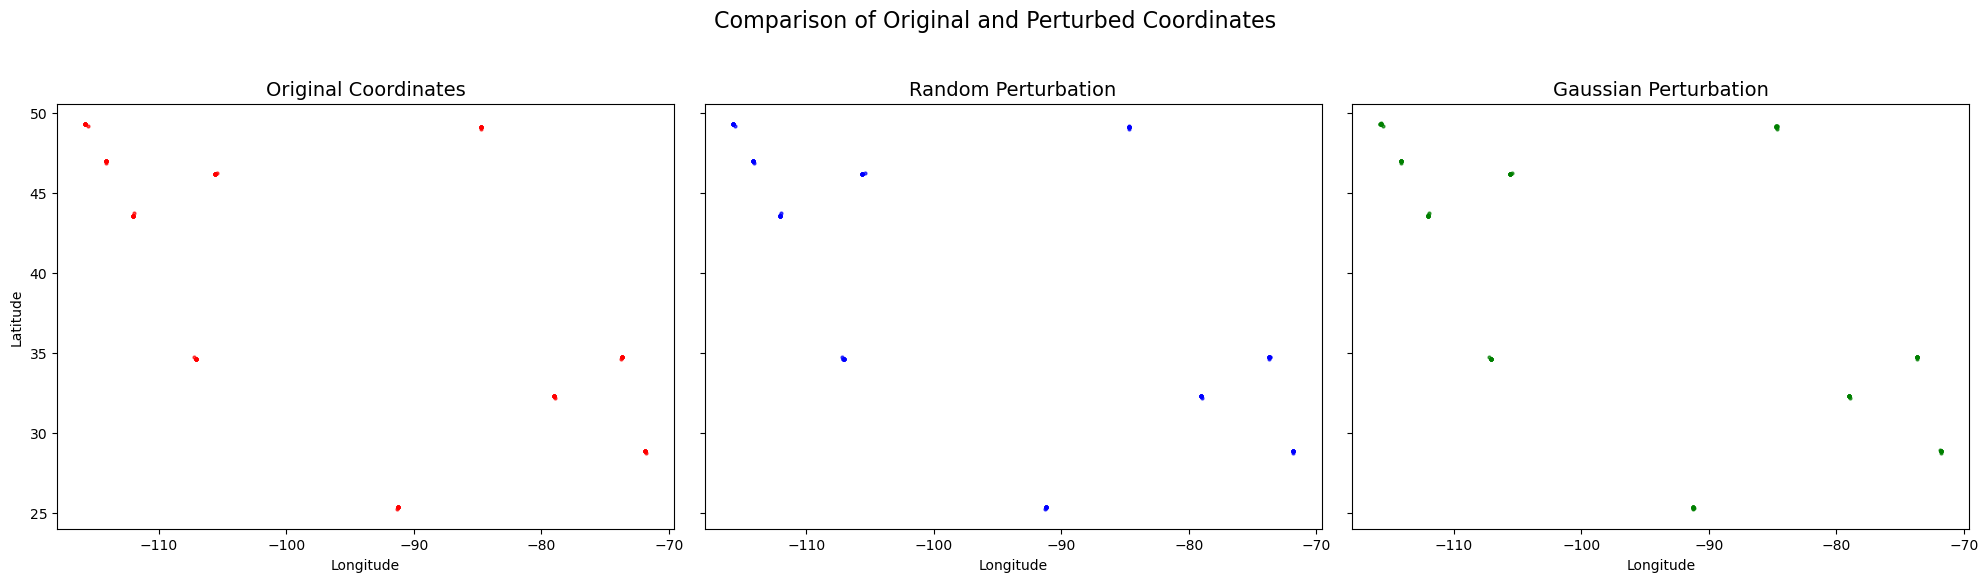

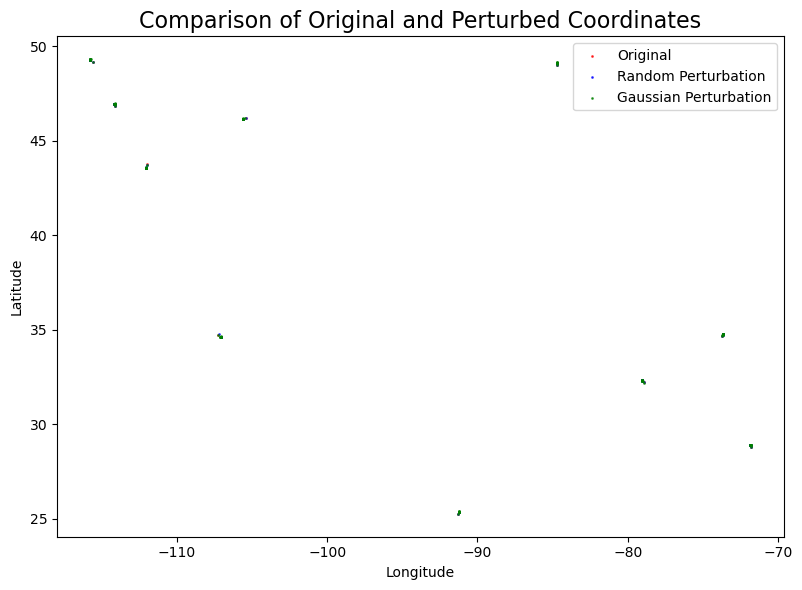

In [101]:
import ast

file_path = 'results.csv'
results_df = pd.read_csv(file_path)

# Convert string representations of lists and tuples to actual Python objects
results_df['RandomPerturbedLatLon'] = results_df['RandomPerturbedLatLon'].apply(ast.literal_eval)
results_df['GaussianPerturbedLatLon'] = results_df['GaussianPerturbedLatLon'].apply(ast.literal_eval)

# Prepare the dataset with original, random, and Gaussian perturbed coordinates as GeoDataFrames
original_geometry = [Point(xy[1], xy[0]) for xy in zip(results_df['Latitude'], results_df['Longitude'])]
random_geometry = [Point(xy[1], xy[0]) for xy in results_df['RandomPerturbedLatLon']]
gaussian_geometry = [Point(xy[1], xy[0]) for xy in results_df['GaussianPerturbedLatLon']]

original_gdf = gpd.GeoDataFrame(results_df, geometry=original_geometry, crs="EPSG:4326")
random_gdf = gpd.GeoDataFrame(results_df, geometry=random_geometry, crs="EPSG:4326")
gaussian_gdf = gpd.GeoDataFrame(results_df, geometry=gaussian_geometry, crs="EPSG:4326")

# Plot the original and perturbed data
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# Original Coordinates
original_gdf.plot(ax=ax[0], color='red', alpha=0.7, markersize=4)
ax[0].set_title("Original Coordinates", fontsize=14)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Random Perturbation
random_gdf.plot(ax=ax[1], color='blue', alpha=0.7, markersize=4)
ax[1].set_title("Random Perturbation", fontsize=14)
ax[1].set_xlabel('Longitude')

# Gaussian Perturbation
gaussian_gdf.plot(ax=ax[2], color='green', alpha=0.7, markersize=4)
ax[2].set_title("Gaussian Perturbation", fontsize=14)
ax[2].set_xlabel('Longitude')

plt.suptitle('Comparison of Original and Perturbed Coordinates', fontsize=16)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))

# Plot all points in the same plot with different colors
original_gdf.plot(ax=plt.gca(), color='red', alpha=0.7, markersize=1, label='Original')
random_gdf.plot(ax=plt.gca(), color='blue', alpha=0.7, markersize=1, label='Random Perturbation')
gaussian_gdf.plot(ax=plt.gca(), color='green', alpha=0.7, markersize=1, label='Gaussian Perturbation')

# Set plot title and labels
plt.title('Comparison of Original and Perturbed Coordinates', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add legend to the plot
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()